In [2]:
import numpy as np
import pandas as pd
import os
from skimage import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.decomposition import PCA


In [3]:
#Tamaño del conjunto de entrenamiento
nTrain = 70

imagenesT = os.listdir("./archive/img_align_celeba/img_align_celeba")
train = np.random.choice(imagenesT, size = nTrain)

#Leemos las imagenes
os.chdir("./archive/img_align_celeba/img_align_celeba")


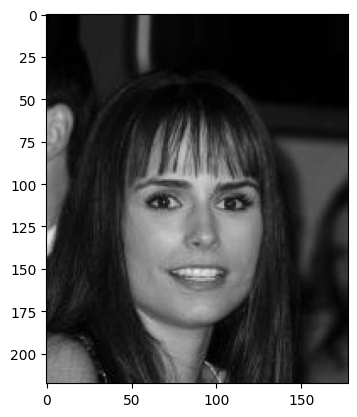

In [4]:
#Convertimos a blanco y negro las imagenes
imagenes = []
for image in train:
    tensor = io.imread(image)/255
    R, G, B = tensor[:,:,0], tensor[:,:,1], tensor[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    imagenes.append(imgGray)

plt.imshow(imagenes[0], vmin=0, vmax=1, cmap = 'gray')

In [5]:
'''
Funcion que divide una imagen en dx x dy parches.
ParcheDim: (x, y) tupla que indica el numero de parches en x y otro en y
'''
def parcha(imagen, parcheDim):
    n, m = imagen.shape
    dx, dy = parcheDim
    miniy, minix = int(n/dy), int(m/dx)
    resy, resx = n - miniy*dx, m - minix*dy

    parches = []
    for i in range(0, n-resy, miniy):
        for j in range(0, m-resx, minix):
            parche = imagen[i:(i+miniy), j:(j+minix)]
            parches.append(parche)
    return parches

'''
Funcion que hace parches de todas las imagenes.
'''
def parchaTodo(conjTrain, parcheDim):
    listaMadre = []

    for imagen in conjTrain:
        parches = parcha(imagen, parcheDim)
        listaMadre.extend(parches)
    return listaMadre

In [6]:
#Separamos
Xtrain, Xtest = train_test_split(imagenes, test_size=0.3, random_state=42)

train = parchaTodo(Xtrain, (8, 8))
test = parchaTodo(Xtest, (8, 8))

## Preparamos los datos para aplicar PCA

In [7]:
def generaX(base):
    n, m = base[0].shape
    X = np.zeros((len(base), n*m))

    i = 0
    for elem in base:
        X[i] = np.reshape(elem, n*m)
        i = i + 1
    return X

X = generaX(train)
Xprueba = generaX(test)

In [8]:
print(X.shape, Xprueba.shape)


(3136, 594) (1344, 594)


In [9]:
#Siempre hay que estandarizar para hacer PCA
Xscaled = sc.fit_transform(X)
XpruebaScaled = sc.transform(Xprueba)
mediar, varr = sc.mean_, sc.var_

In [10]:
pca = PCA()
 
X_train = pca.fit_transform(Xscaled)
trans = pca.components_

varExpl = pca.explained_variance_ratio_
varAcum = np.cumsum(varExpl)

print(' ----- PORCENTAJES REQUERIDOS ------ ')
numeroC = []
per = [0.875, 0.90, 0.925, 0.95, 0.99]
for i in per:
    n = np.sum(varAcum < i)
    print('Para %s de var explicada se necesitan: '%(i), n, ' componentes.')
    print('Total: ', varAcum[n])
    numeroC.append(n)

 ----- PORCENTAJES REQUERIDOS ------ 
Para 0.875 de var explicada se necesitan:  2  componentes.
Total:  0.8886571856060351
Para 0.9 de var explicada se necesitan:  3  componentes.
Total:  0.9050372787158251
Para 0.925 de var explicada se necesitan:  5  componentes.
Total:  0.9312100899850512
Para 0.95 de var explicada se necesitan:  9  componentes.
Total:  0.9512685559569832
Para 0.99 de var explicada se necesitan:  71  componentes.
Total:  0.9900049910406656


## Reconstruccion

In [11]:
'''
Funcion que dados 64 parches reconstruye una imagens
'''
def hasParche(X, Nparches, tamParches):
    n, m = tamParches
    imagen = np.zeros((tamParches[0]*Nparches[0], tamParches[1]*Nparches[1]))

    #Reconstrimos parche por parche
    indI = 0
    cuen = 0
    for i in range(0, Nparches[0]):
        indJ = 0
        for j in range(0, Nparches[1]):
            imagen[indI:(indI + tamParches[0]), indJ:(indJ + tamParches[1])]  = np.reshape(X[cuen], tamParches)
            cuen += 1
            indJ = indJ + tamParches[1]
        indI = indI + tamParches[0]
    return imagen

In [12]:
'''
Funcion que reconstruye cada parche
'''
def proyecta(nComponentes, trans, X, tamParches):
    imagen = []

    eigen = trans[0:nComponentes, :]
    proyeccion = eigen @ X.T

    #Reconstrimos parche por parche
    for i in range(0, len(X)):
        temp = eigen.T @ proyeccion[:, i].T
        temp = temp.real
        imagen.append(np.reshape(temp, tamParches))

    return imagen

In [26]:
'''
Funcion que saca todo el error del conjunto test
'''
def error(X, Xt, nCom, nParches = (8, 8)):
    n, m = imagenes[0].shape
    salto = nParches[0]*nParches[1]
    tamParc = (int(n/nParches[0]), int(m/nParches[1]))
    errores = []

    #Vamos reconstruyendo imagen por imagen
    for i in range(0, len(X), salto):
        original = hasParche(X[i:(i+salto)], nParches, tamParc)
        parches = proyecta(nCom, trans, Xt[i:(i+salto)], tamParc)
        recons = hasParche(parches, nParches, tamParc)
        error = np.sum((original/np.max(original) - recons/np.max(recons))**2)
        errores.append(error)
    return errores


In [27]:
errComp = []
for nc in numeroC:
    errComp.append(error(Xprueba, XpruebaScaled, nc))

resultados = pd.DataFrame({ 'N =' + str(numeroC[0]): errComp[0],
'N =' + str(numeroC[1]): errComp[1],
'N =' + str(numeroC[2]): errComp[2],
'N =' + str(numeroC[3]): errComp[3],
'N =' + str(numeroC[4]): errComp[4],
})

In [28]:
estadisticas = resultados.describe()
print(estadisticas)

               N =2          N =3          N =5          N =9         N =71
count     21.000000     21.000000     21.000000     21.000000     21.000000
mean   16463.963973  13980.238759  12742.041461  12749.990155  11122.723708
std    17070.307551  12119.126645   8398.019819   8768.715605   5489.036163
min     4795.073479   4775.109898   4791.711731   4324.347723   4069.994946
25%     7818.321454   7535.341999   7421.121327   7329.831180   7505.003272
50%     9970.543845   9117.026851   8536.046316   8229.208264   8486.268945
75%    19748.812640  17515.700716  16040.915015  15044.752038  13514.218529
max    84641.719704  60954.732436  39427.739869  42168.858223  23018.526314


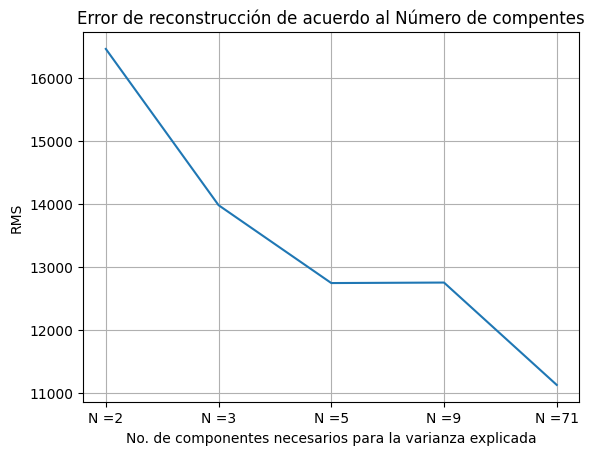

In [29]:
plt.plot(estadisticas.iloc[1, :])
plt.ylabel('RMS')
plt.xlabel('No. de componentes necesarios para la varianza explicada')
plt.title('Error de reconstrucción de acuerdo al Número de compentes')
plt.grid()
plt.show()

## Visualizacion de las reconstrucciones de las 10 imagenes

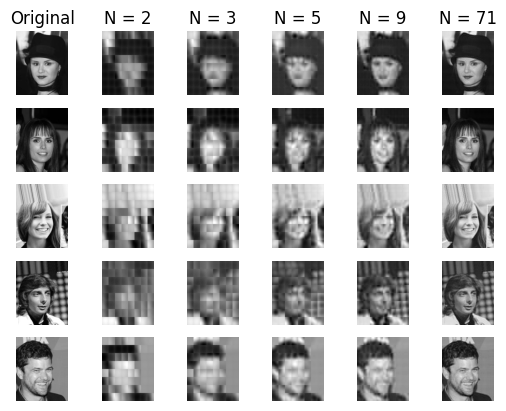

In [22]:
nParches = (8, 8)
n, m = imagenes[0].shape
salto = int(nParches[0]*nParches[1])
tamParc = (int(n/nParches[0]), int(m/nParches[1]))

i, ind = 0, 0
nImag = 5
fig, ax = plt.subplots(nImag, 6) 
for k in range(nImag):
    original = hasParche(Xprueba[i:(i+salto)], nParches, tamParc)

    ax[ind, 0].imshow(original, cmap = 'gray')
    if ind == 0:
        ax[ind, 0].set_title("Original")
    ax[ind, 0].axis('off')
    j = 1
    for nc in numeroC:
        parches = proyecta(nc, trans, XpruebaScaled[i:(i+salto)], tamParc)
        recons = hasParche(parches, nParches, tamParc) 
        ax[ind, j].imshow(recons, cmap = 'gray')
        if ind == 0:
            ax[ind, j].set_title('N = ' + str(nc))
            #print(np.sum((original-recons)**2))
        ax[ind, j].axis('off')
        j = j + 1
    ind = ind + 1
    i += salto
plt.show()

0.7720749019607842 0.8265019370874447
0.7720749019607842 1.0237376946975254
0.7720749019607842 1.0007824310873559
0.7720749019607842 1.0106732528001239
0.7720749019607842 1.1019859922091493


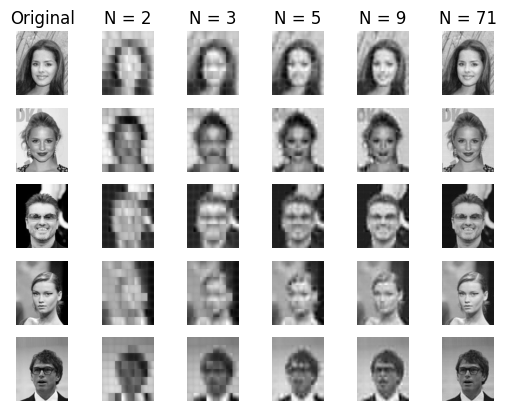

In [25]:
i, ind = 64*5, 0
nImag = 5
fig, ax = plt.subplots(nImag, 6) 
for k in range(nImag):
    original = hasParche(Xprueba[i:(i+salto)], nParches, tamParc)

    ax[ind, 0].imshow(original, cmap = 'gray')
    if ind == 0:
        ax[ind, 0].set_title("Original")
    ax[ind, 0].axis('off')
    j = 1
    for nc in numeroC:
        parches = proyecta(nc, trans, XpruebaScaled[i:(i+salto)], tamParc)
        recons = hasParche(parches, nParches, tamParc) 
        ax[ind, j].imshow(recons, cmap = 'gray')
        if ind == 0:
            ax[ind, j].set_title('N = ' + str(nc))
        ax[ind, j].axis('off')
        j = j + 1
    ind = ind + 1
    i += salto
plt.show()